# 1 - Libraries

In [1]:
%pip install plot_keras_history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=f5d1b12f7a28b7318d48547a8f89a8cb8cdacf35a21ba45c481155ef5db9ea58
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=0f6f8ba0ae9c8655c6ae071667b7898b5e9c16c976dc86515549ab8187a3106b
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5629 sha256=68c5096f27595faa6e45463bf4ce3868c6c7dcef0f190e3931fc23dc563a774f
  Stored in director

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from plot_keras_history import show_history, plot_history

import tensorflow as tf

# For normalization and preparation
import cv2
from skimage.exposure import match_histograms
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

#For tiling
from PIL import Image

# os.environ["TF_KERAS"]='1'
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# 2 - Data collection

In [3]:
# Charger les données
data = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
data['image_path'] = [''.join(['/kaggle/input/UBC-OCEAN/train_thumbnails/', str(x), '_thumbnail.png']) if ''.join([str(x), '_thumbnail.png']) in os.listdir('/kaggle/input/UBC-OCEAN/train_thumbnails') else ''.join(['/kaggle/input/UBC-OCEAN/train_images/', str(x), '.png']) for x in data['image_id']]

In [4]:
# Nombre de classes
nb_lab = len(data['label'].unique())

# Liste des classes
le = LabelEncoder()
le.fit_transform(data['label'])
list_lab = le.classes_

In [5]:
epochs = 15
batch_size = 32

# 3 - Data augmentation

In [6]:
# Fonction d'augmentation des données
def data_flow_fct(data, datagen, data_type=None, batch_size=None) :

    data_flow = datagen.flow_from_dataframe(data,
                                            #directory=dir_, # Pas besoin
                                            x_col='image_path',  # Utilisez 'image_path' comme colonne des chemins d'images
                                            y_col='label',#_name',
                                            weight_col=None,
                                            target_size=(256, 256),
                                            classes=None,
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=42,
                                            subset=data_type)
    return data_flow

In [7]:
# Méthode d'augmentation des données
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,# détermine le ration training/validation
    preprocessing_function=preprocess_input)

# 4 - Train/Val split on augmentated data

In [8]:
# Augmentation des données et split en train et val
train_flow = data_flow_fct(data, datagen_train, data_type='training',batch_size=batch_size)#divisor_train)
val_flow = data_flow_fct(data, datagen_train, data_type='validation',batch_size=batch_size)#divisor_val)

Found 404 validated image filenames belonging to 5 classes.
Found 134 validated image filenames belonging to 5 classes.


# 5 - Normalization

In [9]:
# Fonction de normalisation d'une image
def normalization_processing(image_path):
    # Appliquer une normalisation de l'image sur le modèle d'une image de référence ref_path
    ref_path = r"/kaggle/input/UBC-OCEAN/train_thumbnails/4_thumbnail.png"

    # Charger l'image en couleur
    ref_img = cv2.imread(ref_path, cv2.IMREAD_COLOR)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize des images pour avoir la même taille
    ref_img = cv2.resize(ref_img, (224, 224), interpolation=cv2.INTER_AREA)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)

    # Appliquer la normalisation
    aft_img = match_histograms(image, ref_img)

    # Convert the image to uint8 and BGR
    aft_img = cv2.convertScaleAbs(aft_img, cv2.COLOR_LAB2BGR)

    return aft_img

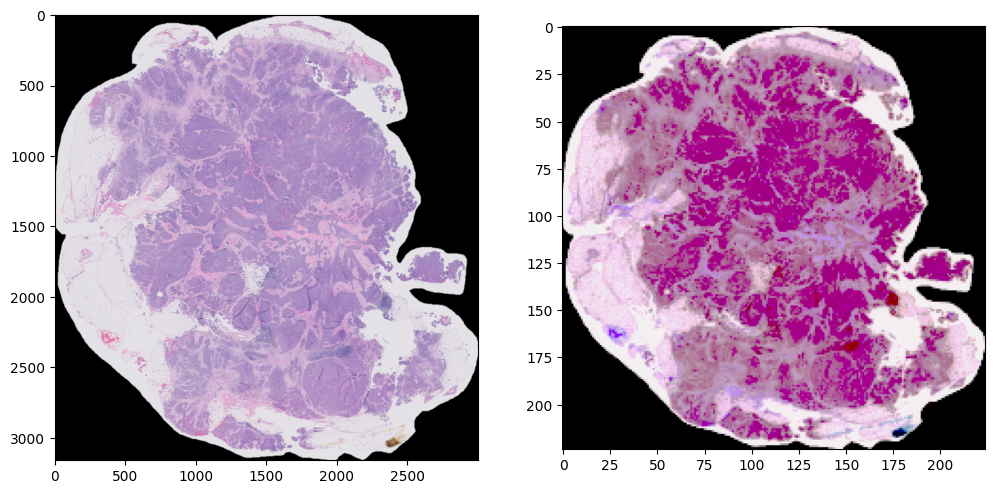

In [10]:
# Afficher une image avant et après normalisation
une_image = '/kaggle/input/UBC-OCEAN/train_thumbnails/10143_thumbnail.png'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(plt.imread(une_image))

ax[1].imshow(normalization_processing(une_image))

plt.show()

# 6 - Tiling

In [15]:
    def pad_to_size(tile, target_size):
        # Calcule la quantité de padding nécessaire
        pad_height = max(0, target_size[0] - tile.shape[0])
        pad_width = max(0, target_size[1] - tile.shape[1])
    
        # Ajoute des colonnes de zéros à gauche et à droite
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
    
        # Ajoute des lignes de zéros en haut et en bas
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
    
        # Applique le padding
        padded_tile = np.pad(tile, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
    
        return padded_tile

    def tiling(image, tile_size=224, pix_threshold=0.6):
        # Découper l'image en petits carreaux
        # 1. Charger l'image
        #image_path = r"C:\Users\John\Desktop\KA-CL-P2-Ovarian_Cancer_Classification\img_paris.png"
        #image = Image.open(image_path)
        
        # 2. Convertir en numpy array
        image_array = np.array(image)
        
        # 3. Tiling de l'image en carreaux de tile_size par tile_size
        #tile_size = 224
        tiles = [pad_to_size(image_array[i:i+tile_size, j:j+tile_size], (tile_size, tile_size, 3)) for i in range(0, image_array.shape[0], tile_size) for j in range(0, image_array.shape[1], tile_size)]
        
        # 4. Élimination des carreaux de taille inférieure à un certain threshold
        threshold = pix_threshold * tile_size**2 * 3 # Vous pouvez ajuster ce seuil en fonction de vos besoins
        filtered_tiles = [tile for tile in tiles if np.sum(tile) > threshold]
        
        # 5. Reconstruction d'un numpy array carré avec les tiles restant
        num_tiles_side = int(np.sqrt(len(filtered_tiles)))
    
        if (len(filtered_tiles) - num_tiles_side**2) != 0:
            num_blank_tiles = (num_tiles_side+1)**2 - num_tiles_side**2
            num_tiles_side = num_tiles_side + 1
        else:
            num_blank_tiles = 0
            
        # Création de tiles blancs
        blank_tile = np.zeros((tile_size, tile_size, 3), dtype=np.uint8)
        
        # Remplissage des tiles manquants avec des tiles blanches
        filled_tiles = filtered_tiles + [blank_tile] * num_blank_tiles
        
        # Reconstruction du numpy array carré
        reconstructed_array = np.vstack([np.hstack(filled_tiles[i*num_tiles_side:(i+1)*num_tiles_side]) for i in range(num_tiles_side)])
        
        # 6. Enregistrement au format png
        #reconstructed_image = Image.fromarray(reconstructed_array)
        reconstructed_image = cv2.convertScaleAbs(reconstructed_array, cv2.COLOR_LAB2BGR)
        reconstructed_image = cv2.resize(reconstructed_image, (224, 224), interpolation=cv2.INTER_AREA)
        
        # base_name = pathpath.basename(image_path)
        # Create the folder if it doesn't exist
        #os.makedirs(r"reconstructed/", exist_ok=True)
        #folder = r"reconstructed/"
        #full_name = ''.join([folder, base_name])
        #reconstructed_image.save(full_name)
        return reconstructed_image
        #return reconstructed_array

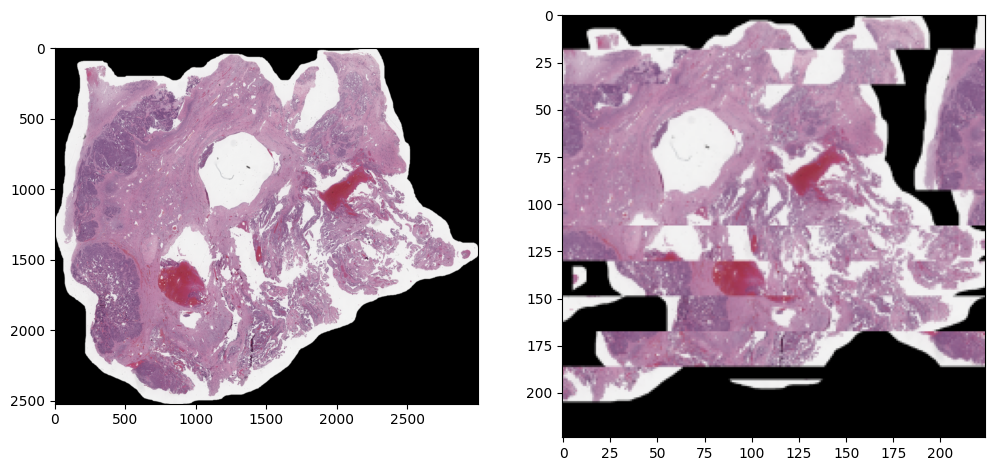

In [16]:
# Afficher une image avant et après tiling
une_image = '/kaggle/input/UBC-OCEAN/train_thumbnails/4_thumbnail.png'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(plt.imread(une_image))

ax[1].imshow(tiling(Image.open(une_image)))

plt.show()

# 7 - Image preparation for VGG16

In [17]:
%%time
# Fonction de préparation des images tilées au format np.array
#3mn36
def image_prep_fct_normalization_tiling(data):
    prepared_images = []
    prepared_images_np = np.empty((0, 0))
    
    for path in data['image_path']:
        img = None
        try:
            # Load tiled image
            img = normalization_processing(path)
            img = tiling(img)
            #print(len(img.shape))
        except:
            # Handle the exception if needed
            print("failed to tile image {path}")
            pass

        # Check the number of channels in the image
        if len(img.shape) == 2:
            # If the image has only one channel, replicate it to create a three-channel image
            img = np.stack((img, img, img), axis=-1)

        # Assuming target_size for img_to_array is (224, 224)
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        #print(img.shape[0], img.shape[1], img.shape[2])
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [18]:
%%time
#6min 34
images_np = image_prep_fct_normalization_tiling(data)
print(images_np.shape)

(538, 224, 224, 3)
CPU times: user 4min 56s, sys: 14.4 s, total: 5min 10s
Wall time: 5min 23s


# 8 - Model training

In [19]:
# Définition des X et y pour le training et validation et des X_test et y_test pour le test
X = images_np
le = LabelEncoder()
labels_encoded = le.fit_transform(data['label'])
y = to_categorical(labels_encoded)

In [ ]:
# Fonction de création du modèle
def create_model_fct() :
    #weights_path = "/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # ATTENTION : activer hors connexion
    weights_path = 'imagenet'
    # Charger le modèle VGG16 pré-entraîné
    #base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model0 = VGG16(include_top=False, weights=weights_path, input_shape=(224, 224, 3)) # ATTENTION : activer hors connexion
    
    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(nb_lab, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [ ]:
%%time
# Création du modèle
# 408ms
with tf.device('/gpu:1'): 
    model = create_model_fct()

# Création du callback
model_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
%%time
# 4min35 for epochs = 1 and batch_size = 32
# Entraîner sur les données d'entraînement
with tf.device('/gpu:0'):
    history = model.fit(train_flow, epochs=epochs, 
                        steps_per_epoch=len(train_flow),
                        callbacks=callbacks_list, 
                        validation_data=val_flow,
                        validation_steps=len(val_flow),
                        verbose=1)

# 9 - Performances

In [ ]:
%%time
# Visualisation de l'évolution des performances/epoch
show_history(history)
plot_history(history, path="history.png")
plt.close()

In [ ]:
%%time
# y_pred
#1min 28 for batch_size = 32
y_pred = model.predict(val_flow, steps=len(val_flow), batch_size=batch_size)

In [ ]:
%%time
# y_val
# 29s for batch_size = 32
# Nombre total d'échantillons dans le jeu de validation
nombre_total_val = len(val_flow) * batch_size

# Initialisation d'un tableau pour stocker les étiquettes réelles
y_val = np.zeros((nombre_total_val, nb_lab))  

# Itérer sur le générateur pour extraire les étiquettes réelles
for i in range(len(val_flow)):
    _, batch_y_val = val_flow[i]  # Supposons que le générateur génère des paires (X_val, y_val)
    start_index = i * batch_size
    end_index = start_index + len(batch_y_val)
    y_val[start_index:end_index] = batch_y_val

# Maintenant, y_val contient les étiquettes réelles correspondantes aux prédictions

In [ ]:
# Générer la matrice de confusion
cm = confusion_matrix(y_val.argmax(axis=1)[0:len(y_pred)], y_pred.argmax(axis=1))

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(cm)

# Afficher le rapport de classification
print("\nRapport de classification :")
print(classification_report(y_val.argmax(axis=1)[0:len(y_pred)], y_pred.argmax(axis=1)))

In [ ]:
df_cm = pd.DataFrame(cm, index=list_lab, columns=list_lab)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

# Ajouter des étiquettes aux axes
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

plt.show()